# **ANÁLISIS EXPLOTARIO DE LA PLATAFORMA DE COMERCIO ELECTRÓNICO DE OLIST STORE**

**OBJETIVO:** OLIST STORE BUSCA ATRAER A NUEVOS CLIENTES, FIDELIZAR A LOS CLIENTES FRECUENTES Y MEJORAR LAS VENTAS DE LOS VENDEDORES. CON LA FINALIDAD DE CUMPLIR CON DICHOS OBJETIVOS, EL PRESENTE NOTEBOOK BUSCA ENCONTRAR LOS INSIGHTS SIGNIFICATIVOS PARA EL ÁREA DE GERENCIA Y BRINDAR RECOMENDACIONES FINALES

# **1. Limpieza y Preprocesamiento de datos**

## **1.1. Carga de datos**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_data(path,sep=','):
  return pd.read_csv(path,sep=sep)

In [3]:
path = '/content/drive/MyDrive/Machine Learning/Ecommerce/dataset'

En la celda anterior definimos nuestro path que contiene la ruta de nuestros datasets

In [4]:
df_order_items = load_data(path+'/olist_order_items_dataset.csv')
df_order_payments = load_data(path+'/olist_order_payments_dataset.csv')
df_geolocation = load_data(path+'/olist_geolocation_dataset.csv')
df_reviews = load_data(path+'/olist_order_reviews_dataset.csv')
df_products = load_data(path+'/olist_products_dataset.csv')
df_customers = load_data(path+'/olist_customers_dataset.csv')
df_orders = load_data(path+'/olist_orders_dataset.csv')
df_sellers = load_data(path+'/olist_sellers_dataset.csv')
df_products_category = load_data(path+'/product_category_name_translation.csv')

Hemos cargado nuestros datasets mediante la función **load_data**

## **1.2. Exploración y Tratamiento para datos duplicados**

### **1.2.1. Order_items**

In [5]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [6]:
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
df_order_items[df_order_items['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


En la celda anterior, realizamos un filtro de una orden de compra para observar el comportamiento de los datos. Por lo tanto, concluimos lo siguiente:
* Se pueden **agrupar mejor los datos, por orden_id y product_id para obtener el precio total del producto, el precio total de transporte y el precio total de la orden**

In [8]:
def orders_groupby_product(df_o):
  # Definir las operaciones que necesitamos agregar
  dict_operations = {'product_id':['count'],'price':[sum],'freight_value': [sum]}

  # Agrupar todas nuestras columnas, añadiendo el conteo de productos, el valor total del producto y el valor total del transporte
  df = df_o.groupby(['order_id','product_id',]).agg(dict_operations).reset_index()

  # Las agrupaciones general multi-indices, por eso vamos a concatenar las ultimas 3 columnas en un solo nivel
  df.columns = ['_'.join(col) for col in df.columns.values]

  # Cambiando el nombre de las columnas que hemos obtenido
  df.rename(columns = {'product_id_count':'products_amount_','price_sum':'total_product_value_','freight_value_sum':'total_freight_value_'}, inplace = True)

  # Eliminando el último caracter de las columnas
  df.columns = [col[:-1] for col in df.columns.values]

  # Eliminamos las columnas que no son de interés
  df_o = df_o.drop(['order_item_id','price','freight_value'],axis=1)

  # Realizamos un merge con nuestro dataframe de ordenes
  df = pd.merge(df,df_o,on=['order_id','product_id'],how='inner')

  # Eliminamos los datos duplicados
  df = df.drop_duplicates()

  # Creamos una nueva columna para almacenar el valor total del pedido
  df['total_order_value'] = df['total_product_value'] + df['total_freight_value']

  return df

En la función anterior realizamos un procesamiento para agrupar los datos en función al orden_id y product_id

In [9]:
df_order_items = orders_groupby_product(df_order_items)
df_order_items[df_order_items['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,product_id,products_amount,total_product_value,total_freight_value,seller_id,shipping_limit_date,total_order_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a,3,63.99,45.3,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,109.29


En la cenda anterior hemos comprobado con la misma orden, que hemos obtenido los valores que necesitamos: **La orden de id '00143d0f86d6fbd9f9b38ab440ac16f5' tiene 3 unidades de producto, con un valor total de la orden de 109.20(toal de producto de 66.99 + un total de 45.3 en transporte)**

### **1.2.2. Order_payments**

In [10]:
df_order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [11]:
df_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [12]:
df_order_payments[df_order_payments['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
29413,00143d0f86d6fbd9f9b38ab440ac16f5,1,credit_card,1,109.29


En el dataframe mostrado, observamos que ya tenemos los datos resumidos

### **1.2.3. Geolocation**

In [13]:
df_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [14]:
df_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [15]:
df_geolocation[df_geolocation.duplicated()].shape

(261831, 5)

En la celda anterior podemos visualizar que tenemos 261 831 filas con datos duplicados en geolocalización. Estos inconvenientes se pueden presentar por errores de registros de datos de los usuarios finales

In [16]:
df_geolocation = df_geolocation[~df_geolocation.duplicated()]

### **1.2.4. Reviews**

In [17]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [18]:
df_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


### **1.2.5. Products**

In [19]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [20]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


### **1.2.6. Customers**

In [21]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [22]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [23]:
df_customers['customer_unique_id'].value_counts()

8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
ca77025e7201e3b30c44b472ff346268     7
6469f99c1f9dfae7733b25662e7f1782     7
                                    ..
081f07439678af2da7755a0aa572154d     1
9c57789a6a587f4efcfb01e36c106014     1
9e4c21635f640562de1a6976374fba03     1
06c0ea6ee892364d1608ee47aa9f56a0     1
84732c5050c01db9b23e19ba39899398     1
Name: customer_unique_id, Length: 96096, dtype: int64

In [24]:
df_customers[df_customers['customer_unique_id']=='1b6c7548a2a1f9037c1fd3ddfed95f33']

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
7012,53e16f83735cfe02bf83ef6481ca241e,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG
12164,95b9cacc4bc81c3a0a33967bcde6fcd8,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG
16824,41a16488effb86580d7a89f8aa19a03b,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG
24987,fff7466a253c0e59499ea943462c10f9,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG
50663,c2ff01bd4fa72f9487ee397f6c5989d2,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG
65287,9a4578c9dd9dce6517d583cb5eca0276,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG
66714,ee5c2e36a79081c2440e61990ec2f3af,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG


En la celda anterior, realizamos un filtro de un cliente para observar el comportamiento de los datos. Por lo tanto, concluimos lo siguiente:
* Se pueden **agrupar mejor los datos, por customer_unique_id para visualizar el número de compras que ha realizado un determinado cliente**

In [25]:
def customers_groupby_uniqueID(df_c):
  # Definir las operaciones que necesitamos agregar
  dict_operations = {'customer_unique_id':['count']}

  # Agrupar todas nuestras columnas, añadiendo el conteo de compras (número de veces que aparece un customer_unique_id)
  df = df_c.groupby(['customer_unique_id']).agg(dict_operations).reset_index()

  # Las agrupaciones general multi-indices, por eso vamos a concatenar las ultimas 3 columnas en un solo nivel
  df.columns = ['_'.join(col) for col in df.columns.values]

  # Cambiando el nombre de las columnas que hemos obtenido
  df.rename(columns = {'customer_unique_id_count':'frequency_purchase_customer_'}, inplace = True)

  # Eliminando el último caracter de las columnas
  df.columns = [col[:-1] for col in df.columns.values]

  # Realizamos un merge con nuestro dataframe de ordenes
  df = pd.merge(df,df_c,on=['customer_unique_id'],how='inner')

  # Eliminamos los datos duplicados
  df = df.drop_duplicates()

  return df

En la función anterior realizamos un procesamiento para agrupar los datos en función al customer_unique_id

In [26]:
df_customers = customers_groupby_uniqueID(df_customers)
df_customers[df_customers['customer_unique_id']=='1b6c7548a2a1f9037c1fd3ddfed95f33']

,customer_unique_id,frequency_purchase_customer,customer_id,customer_zip_code_prefix,customer_city,customer_state
10711,1b6c7548a2a1f9037c1fd3ddfed95f33,7,53e16f83735cfe02bf83ef6481ca241e,38301,ituiutaba,MG
10712,1b6c7548a2a1f9037c1fd3ddfed95f33,7,95b9cacc4bc81c3a0a33967bcde6fcd8,38301,ituiutaba,MG
10713,1b6c7548a2a1f9037c1fd3ddfed95f33,7,41a16488effb86580d7a89f8aa19a03b,38301,ituiutaba,MG
10714,1b6c7548a2a1f9037c1fd3ddfed95f33,7,fff7466a253c0e59499ea943462c10f9,38301,ituiutaba,MG
10715,1b6c7548a2a1f9037c1fd3ddfed95f33,7,c2ff01bd4fa72f9487ee397f6c5989d2,38301,ituiutaba,MG
10716,1b6c7548a2a1f9037c1fd3ddfed95f33,7,9a4578c9dd9dce6517d583cb5eca0276,38301,ituiutaba,MG
10717,1b6c7548a2a1f9037c1fd3ddfed95f33,7,ee5c2e36a79081c2440e61990ec2f3af,38301,ituiutaba,MG


En la cenda anterior hemos comprobado con el mismo cliente, que hemos obtenido los valores que necesitamos. **El cliente de customer_unique_id de '1b6c7548a2a1f9037c1fd3ddfed95f33' ha comprado 7 veces en OlistStore**

### **1.2.7. Orders**

In [27]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [28]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [29]:
df_orders[df_orders['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
36265,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06 00:00:00


### **1.2.8. Sellers**

In [30]:
df_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [31]:
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


### **1.2.9. Products_Category**

In [32]:
df_products_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [33]:
df_products_category.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


Observamos que se ha ejecutado la información general de cada dataframe generado

In [34]:
def df_summary(dfs,names):
  df = pd.DataFrame({},)
  df['datasets']= names
  df['total_duplicate']= [len(data[data.duplicated()]) for data in dfs]
  df['total_null']= [data.isnull().sum().sum() for data in dfs]
  return df

In [35]:
all_df = [df_order_items,df_order_payments,df_geolocation,df_reviews,df_products,df_customers,df_orders,df_sellers,df_products_category]
all_names = ['df_order_items','df_order_payments','df_geolocation','df_reviews','df_products','df_customers','df_orders','df_sellers','df_products_category']
df_summary(all_df,all_names)

,datasets,total_duplicate,total_null
0,df_order_items,0,0
1,df_order_payments,0,0
2,df_geolocation,0,0
3,df_reviews,0,145903
4,df_products,0,2448
5,df_customers,0,0
6,df_orders,0,4908
7,df_sellers,0,0
8,df_products_category,0,0


En el dataframe mostrado, hemos encontrado los siguientes hallazgos:
*   El dataframe **df_geolocation** tiene 261 831 registros duplicados
*   El dataframe **df_productos** tiene 2 448 registros con datos vacios
*   El dataframe **df_orders** tiene 4 908 registros con datos vacios



## **1.3. Tratamiento para datos perdidos**

### **1.3.1. Products**

In [36]:
def df_missing_values(df):
  all_missing_values = df.isna().sum()
  percentage_missing_values = all_missing_values/len(df)*100
  df_mv = pd.DataFrame(data=[all_missing_values,percentage_missing_values])
  df_mv = df_mv.T
  df_mv.columns=["Missing Values","Percentage"]
  return df_mv

In [37]:
df_missing_values(df_products)

,Missing Values,Percentage
product_id,0.0,0.000000
product_category_name,610.0,1.851234
product_name_lenght,610.0,1.851234
product_description_lenght,610.0,1.851234
product_photos_qty,610.0,1.851234
product_weight_g,2.0,0.006070
product_length_cm,2.0,0.006070
product_height_cm,2.0,0.006070
product_width_cm,2.0,0.006070


In [38]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


Hemos visualizado que tenemos los siguientes hallazgos en **df_products**:
*  Hay 610 registros que no tenemos datos principales de los productos (categoria y cantidad de caracteres del nombre descripción y fotos)
*  Hay 2 registros que no tenemos datos de presentación de productos (largo, ancho y alto)


In [39]:
df_products = df_products[~df_products['product_category_name'].isnull()]
df_missing_values(df_products)

,Missing Values,Percentage
product_id,0.0,0.000000
product_category_name,0.0,0.000000
product_name_lenght,0.0,0.000000
product_description_lenght,0.0,0.000000
product_photos_qty,0.0,0.000000
product_weight_g,1.0,0.003092
product_length_cm,1.0,0.003092
product_height_cm,1.0,0.003092
product_width_cm,1.0,0.003092


En la celda anterior, observamos que **excluimos los registros de productos que no tienen datos principales de productos porque estos ya pierden relevancia en el dataframe**. Sin embargo, tenemos un registro que presenta valores perdidos en los datos de presentación del producto

In [40]:
df_products[df_products['product_weight_g'].isnull()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN


Hemos observado que del registro que estabamos mencionando anteriormente, **corresponde a la categoría de bebes**

In [41]:
condition = (df_products['product_category_name'] == 'bebes') 
df_products[condition]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
11,03b63c5fc16691530586ae020c345514,bebes,49.0,728.0,4.0,7150.0,50.0,19.0,45.0
23,8b41fbc2b984a12030090112324d1bc4,bebes,55.0,1627.0,1.0,500.0,20.0,13.0,13.0
35,5370b82a213393979691c98074265584,bebes,52.0,708.0,9.0,7950.0,33.0,30.0,44.0
43,b864b103180d5a6a3f830e67f93e8735,bebes,47.0,980.0,4.0,600.0,70.0,11.0,11.0
...,...,...,...,...,...,...,...,...,...
32823,cba32576375902a87170bedaed045b71,bebes,58.0,1882.0,4.0,11467.0,35.0,57.0,52.0
32851,026311ea0b72ef8c80ebf91efd36b499,bebes,52.0,708.0,1.0,300.0,18.0,8.0,24.0
32853,34c84b2e246f5904a5b3597b00240ea2,bebes,55.0,1636.0,1.0,600.0,20.0,13.0,13.0
32935,d4484cc239fbd0ac671ab04d931edc66,bebes,42.0,414.0,2.0,150.0,23.0,15.0,15.0


Hemos encontrado 919 registros de **productos para bebes** que presenta caracteristicas similares al registro que contiene valores nulos. Podemos imputar sus valores utilizando **la mediana** porque es resistente a los datos atípicos (https://www.dm.uba.ar/materias/probabilidades_estadistica_C/2005/1/PyEC012.pdf)

In [42]:
df_products['product_weight_g'] = df_products['product_weight_g'].fillna(df_products[condition]['product_weight_g'].median())
df_products['product_length_cm'] = df_products['product_length_cm'].fillna(df_products[condition]['product_length_cm'].median())
df_products['product_height_cm'] = df_products['product_height_cm'].fillna(df_products[condition]['product_height_cm'].median())
df_products['product_width_cm'] = df_products['product_width_cm'].fillna(df_products[condition]['product_width_cm'].median())

### **1.3.2. Orders**

In [43]:
df_missing_values(df_orders)

,Missing Values,Percentage
order_id,0.0,0.000000
customer_id,0.0,0.000000
order_status,0.0,0.000000
order_purchase_timestamp,0.0,0.000000
order_approved_at,160.0,0.160899
order_delivered_carrier_date,1783.0,1.793023
order_delivered_customer_date,2965.0,2.981668
order_estimated_delivery_date,0.0,0.000000


In [44]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Hemos visualizado que tenemos los siguientes hallazgos en **df_orders**:
*  Hay registros vacios en los campos de fecha de las órdenes de compra

In [45]:
df_orders = df_orders[~df_orders.isnull()]

En la celda anterior, observamos que **excluimos los registros de órdenes de compra que no tienen datos de fecha debido a que pierden relevancia en el dataframe**

### **1.3.3. Reviews**

In [46]:
df_missing_values(df_reviews)

,Missing Values,Percentage
review_id,0.0,0.000000
order_id,0.0,0.000000
review_score,0.0,0.000000
review_comment_title,87656.0,88.341530
review_comment_message,58247.0,58.702532
review_creation_date,0.0,0.000000
review_answer_timestamp,0.0,0.000000


In [47]:
df_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


Hemos visualizado que tenemos los siguientes hallazgos en **df_reviews**:
*  Hay registros vacios en los campos del titulo y mensaje de los comentarios

In [48]:
df_reviews = df_reviews[~df_reviews.isnull()]

En la celda anterior, observamos que **excluimos los registros de comentarios que no tienen datos en el título y mensaje debido a que pierden relevancia en el dataframe**

## **1.4. Merge de datos**

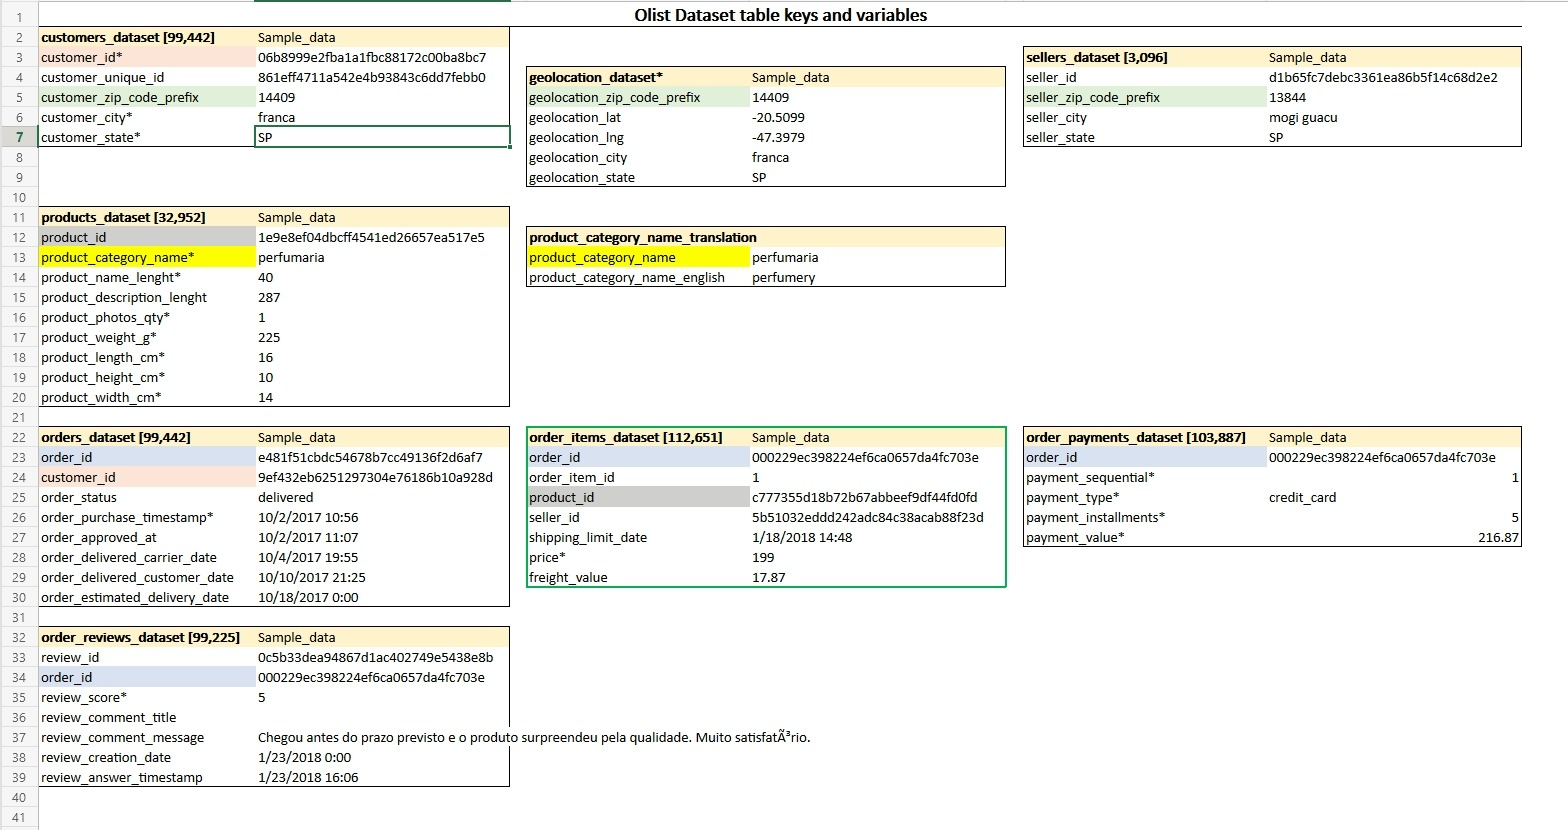

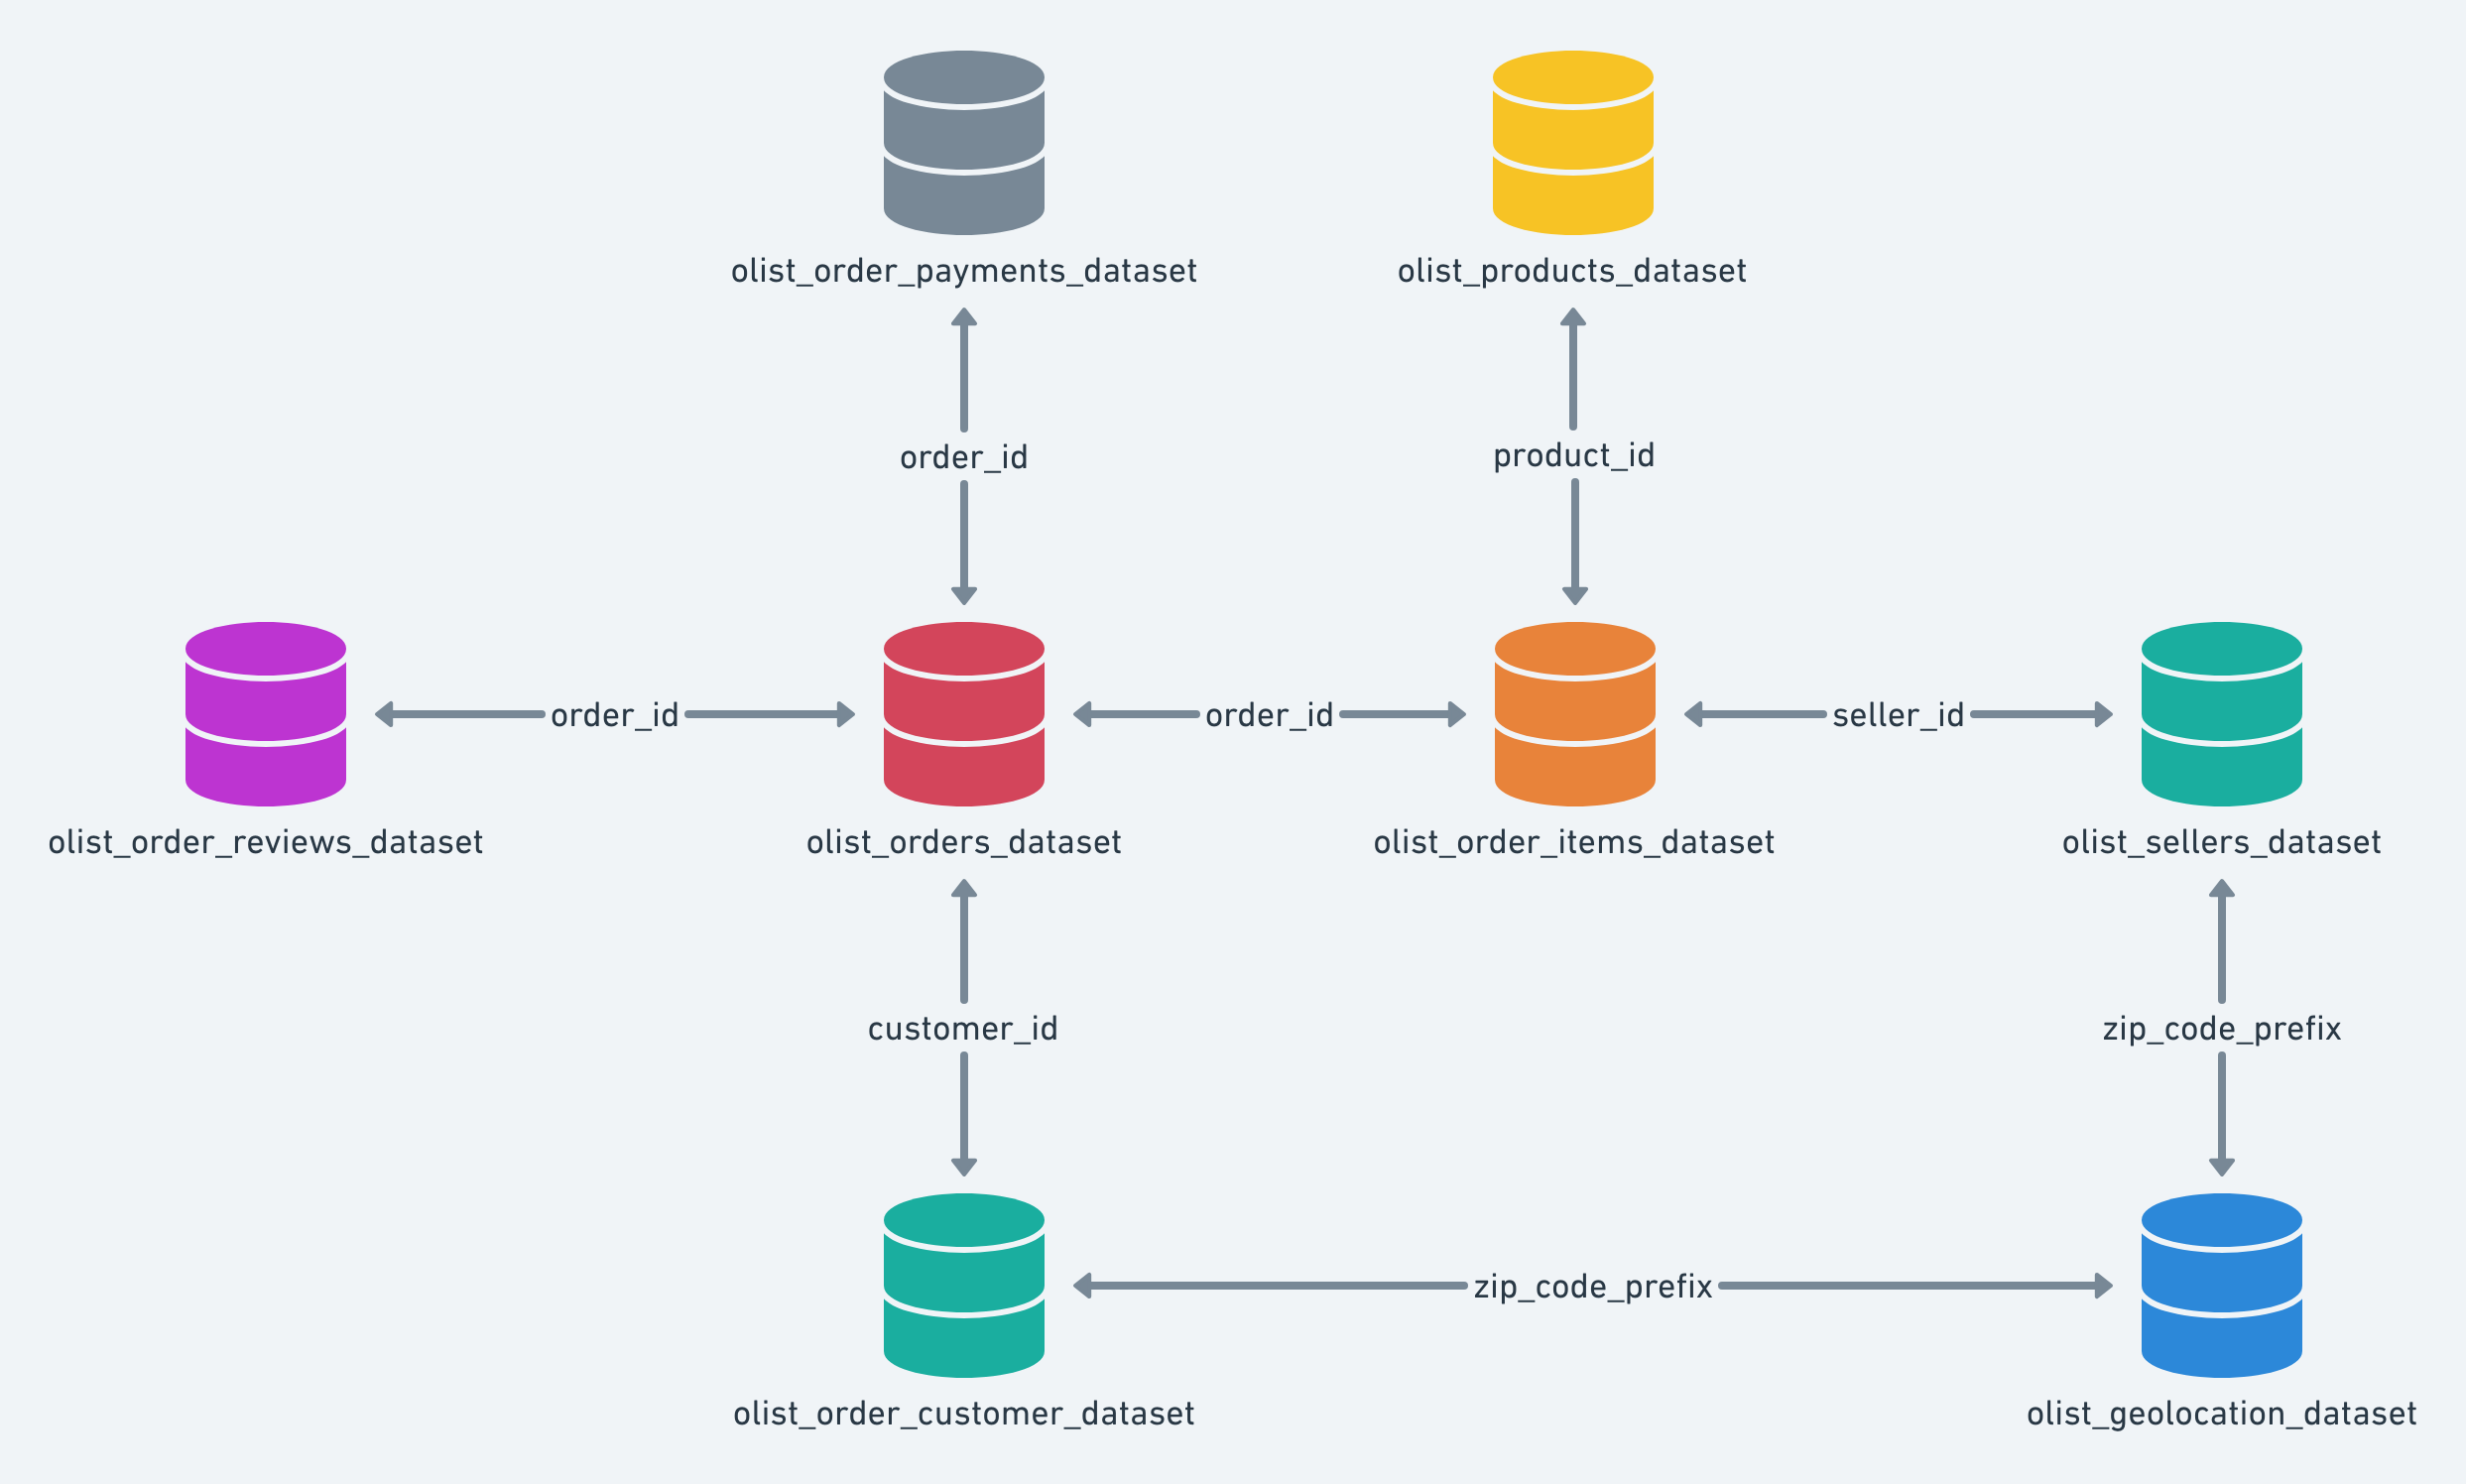

En las imágenes anteriores, podemos visualizar la relaciones de nuestros dataframes y las llaves primarias para lograr el merge

In [49]:
df_order_items.drop(['shipping_limit_date'],axis=1,inplace=True)
df_order_items.shape

(102425, 7)

En la tabla de **df_order_items** consideramos el campo de limite de fecha de envio de producto no es relevante para nuestro modelo

In [50]:
df_order_payments.shape

(103886, 5)

In [51]:
df_geolocation.drop(['geolocation_lat','geolocation_lng','geolocation_state','geolocation_city'],axis=1,inplace=True)
df_geolocation.shape

(738332, 1)

En la tabla de **df_geolocation** consideramos que los datos de latitud, longitud y estado de geolocalización no son relevantes para nuestro modelo

In [52]:
df_reviews.drop(['review_comment_title','review_comment_message','review_creation_date','review_answer_timestamp'],axis=1,inplace=True)
df_reviews.shape

(99224, 3)

En la tabla de **df_reviews** consideramos que el titulo y mensaje de los comentarios no son relevantes para nuestro modelo

In [53]:
df_products.drop(['product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm'],axis=1,inplace=True)
df_products.shape

(32341, 2)

En la tabla de **df_products** consideramos los campos de longitud de caracteres y presentación de producto no son relevantes para nuestro modelo

In [54]:
df_customers.drop(['customer_state'],axis=1,inplace=True)
df_customers.shape

(99441, 5)

En la tabla de **df_customers** consideramos los 2 campos mostrados no son relevantes para nuestro modelo

In [55]:
df_orders.drop(['order_approved_at','order_delivered_carrier_date'],axis=1,inplace=True)
df_orders.shape

(99441, 6)

En la tabla de **df_orders** consideramos los campos de fecha de la celda anterior no son relevantes para nuestro modelo

In [56]:
df_sellers.drop(['seller_state'],axis=1,inplace=True)
df_sellers.shape

(3095, 3)

En la tabla de **df_sellers** consideramos que seller_state no es relevante para nuestro modelo

In [57]:
df_products_category.shape

(71, 2)

In [58]:
def drop_ids(df):
  # Eliminar columnas de ID
  df.drop(['order_id','customer_id','customer_unique_id','product_id','seller_id','review_id','customer_zip_code_prefix','geolocation_zip_code_prefix','seller_zip_code_prefix'],axis=1,inplace=True)
  return df

In [59]:
def merge_data():

  # Merge de productos
  df_p = pd.merge(df_products,df_products_category,on=['product_category_name'])
  df_p.drop(["product_category_name"], axis=1, inplace=True)
  df_p = df_p.rename(columns={"product_category_name_english":"product_category_name"})

  # Merge de clientes
  df_c = pd.merge(df_customers,df_geolocation,left_on=['customer_zip_code_prefix'],right_on=['geolocation_zip_code_prefix'])

  # Merge final
  df_o = pd.merge(df_orders,df_order_items,on=['order_id'])
  df_o = pd.merge(df_o,df_order_payments,on=['order_id'])
  df_o = pd.merge(df_o,df_reviews,on=['order_id'])
  df_o = pd.merge(df_o,df_p,on=['product_id'])
  df_o = pd.merge(df_o,df_c,on=['customer_id'])
  df_o = pd.merge(df_o,df_sellers,on=['seller_id'])
  
  return df_o

In [60]:
def convert_date_column(df):
  date_columns = ['order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date']
  for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
  return df

In [61]:
df_olist = merge_data()
df_olist = convert_date_column(df_olist)

In [62]:
def save_df(df):
  df.to_csv(path+'/merge_olist.csv')

In [63]:
#save_df(df_olist)

En la celda anterior guardamos los resultados del merge, se utilizará en un próximo notebook

In [64]:
df_olist = drop_ids(df_olist)

In [65]:
df_olist['order_year'] = df_olist['order_purchase_timestamp'].apply(lambda x: x.year)
df_olist['is_early_delivery'] = (df_olist['order_estimated_delivery_date'] - df_olist['order_delivered_customer_date']).dt.days.apply(lambda x: 1 if x>=0 else 0)
df_olist.drop(['order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date'],axis=1,inplace=True)
df_olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10961273 entries, 0 to 10961272
Data columns (total 16 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   order_status                 object 
 1   products_amount              int64  
 2   total_product_value          float64
 3   total_freight_value          float64
 4   total_order_value            float64
 5   payment_sequential           int64  
 6   payment_type                 object 
 7   payment_installments         int64  
 8   payment_value                float64
 9   review_score                 int64  
 10  product_category_name        object 
 11  frequency_purchase_customer  int64  
 12  customer_city                object 
 13  seller_city                  object 
 14  order_year                   int64  
 15  is_early_delivery            int64  
dtypes: float64(4), int64(7), object(5)
memory usage: 1.4+ GB


En la celda anterior hemos creado medidas de interés que serán evaluadas mas adelante

In [66]:
df_olist.describe()

,products_amount,total_product_value,total_freight_value,total_order_value,payment_sequential,payment_installments,payment_value,review_score,frequency_purchase_customer,order_year,is_early_delivery
count,1.096127e+07,1.096127e+07,1.096127e+07,1.096127e+07,1.096127e+07,1.096127e+07,1.096127e+07,1.096127e+07,1.096127e+07,1.096127e+07,1.096127e+07
mean,1.102805e+00,1.333747e+02,2.179652e+01,1.551712e+02,1.091693e+00,2.932366e+00,1.580185e+02,4.078890e+00,1.087538e+00,2.017532e+03,9.079029e-01
std,4.592035e-01,2.049246e+02,1.938337e+01,2.137661e+02,6.655607e-01,2.767650e+00,2.175877e+02,1.358297e+00,3.818347e-01,5.060819e-01,2.891629e-01
min,1.000000e+00,8.500000e-01,0.000000e+00,7.280000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.016000e+03,0.000000e+00
25%,1.000000e+00,4.500000e+01,1.396000e+01,6.088000e+01,1.000000e+00,1.000000e+00,5.864000e+01,4.000000e+00,1.000000e+00,2.017000e+03,1.000000e+00
50%,1.000000e+00,8.299000e+01,1.695000e+01,1.017300e+02,1.000000e+00,2.000000e+00,1.033600e+02,5.000000e+00,1.000000e+00,2.018000e+03,1.000000e+00
75%,1.000000e+00,1.487000e+02,2.285000e+01,1.710800e+02,1.000000e+00,4.000000e+00,1.782100e+02,5.000000e+00,1.000000e+00,2.018000e+03,1.000000e+00
max,2.000000e+01,1.344000e+04,1.794960e+03,1.366408e+04,2.900000e+01,2.400000e+01,1.366408e+04,5.000000e+00,1.700000e+01,2.018000e+03,1.000000e+00


## **1.5. Tratamiento de outliers**

En la celda anterior, hemos agregado 4 columnas que nos permitirán realizar análisis más adelante

In [67]:
def subplots_boxplot(size,df):
  features= df.select_dtypes(exclude=['object','datetime64[ns]']).columns
  plt.figure(figsize=size)
  for i in range(len(features)):
    f = math.ceil(len(features)/2)
    c = i+1 if i<len(features) else i-1
    plt.subplot(f,2,c)
    sns.boxplot(x=df[features[i]])

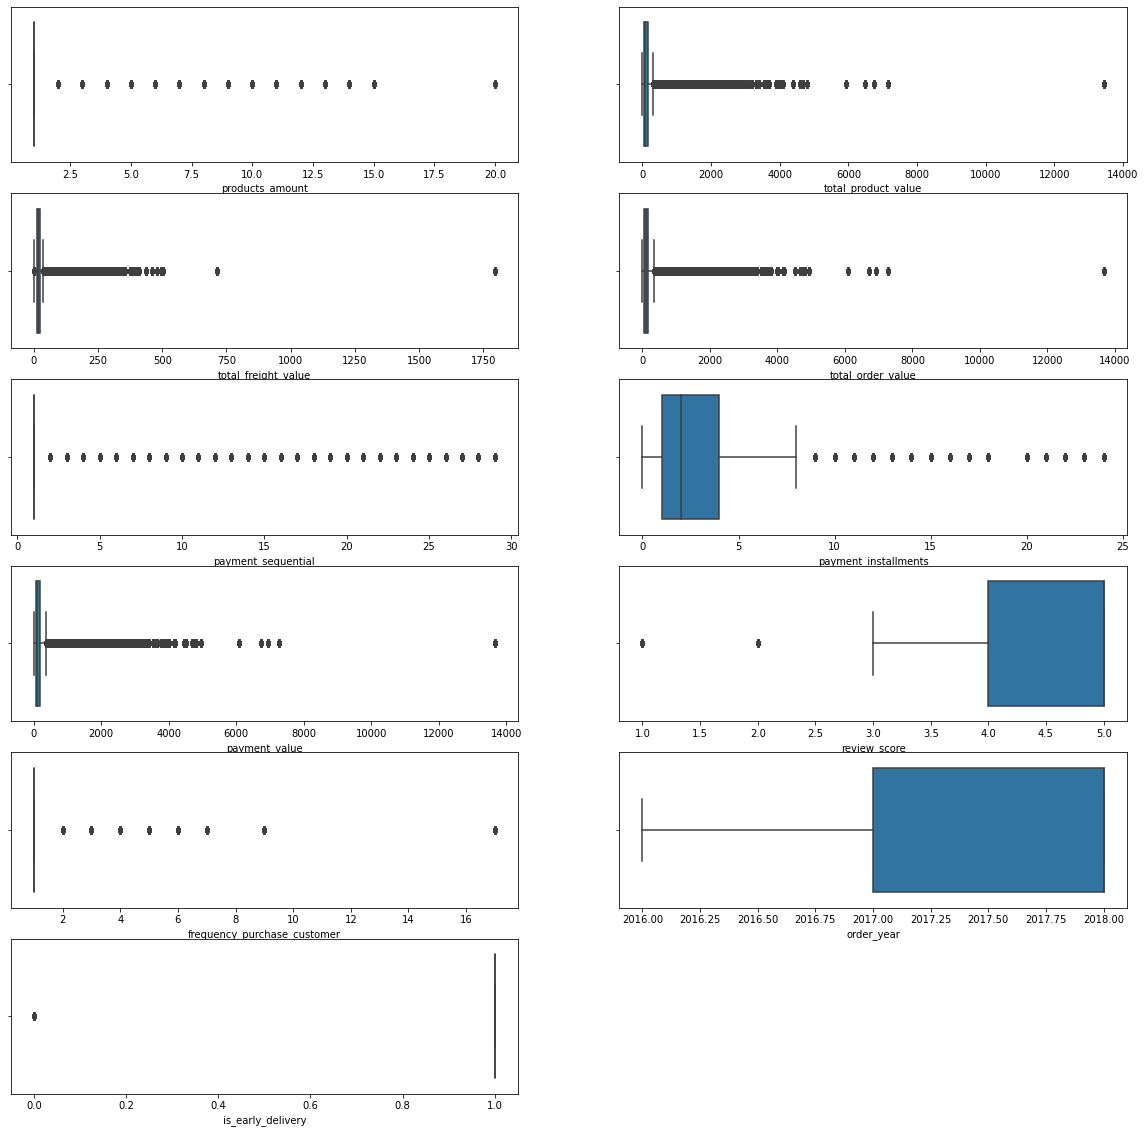

In [68]:
subplots_boxplot((20,20),df_olist)

In [69]:
def identify_outliers(df):
  for i in df.describe().columns:
    Q1 = df.describe().at['25%', i]
    Q3 = df.describe().at['75%', i]
    IQR = Q3-Q1
    LTV = Q1 - 1.5 * IQR 
    UTV = Q3 + 1.5 * IQR 
    print('Nombre de Columna                                         :', i)
    print('Rango Intercuartil IQR                                    :', IQR)
    print('Datos en Limite Inferior                                  :', LTV)
    print('Datos en Limite Superior                                  :', UTV)
    print('Número de outliers por debajo del bigote inferior         :', df[df[i] < LTV][i].count())
    print('Número de outliers por encima del bigote superior         :', df[df[i] > UTV][i].count())
    print('Total de Ourliers                                         :', (df[df[i] < LTV][i].count()) + (df[df[i] > UTV][i].count()))
    print('\n')

In [70]:
identify_outliers(df_olist)

Nombre de Columna                                         : products_amount
Rango Intercuartil IQR                                    : 0.0
Datos en Limite Inferior                                  : 1.0
Datos en Limite Superior                                  : 1.0
Número de outliers por debajo del bigote inferior         : 0
Número de outliers por encima del bigote superior         : 788102
Total de Ourliers                                         : 788102


Nombre de Columna                                         : total_product_value
Rango Intercuartil IQR                                    : 103.69999999999999
Datos en Limite Inferior                                  : -110.54999999999998
Datos en Limite Superior                                  : 304.25
Número de outliers por debajo del bigote inferior         : 0
Número de outliers por encima del bigote superior         : 807316
Total de Ourliers                                         : 807316


Nombre de Columna             

Luego de revisar las celdas anteriores, vamos a realizar la imputación por rango intercuartílico a todos los campos excepto: 

* **payment_sequential** y **payment_installments** debido a que por su naturaleza, representa valores cualitativo ordinales (indican orden) 
* **review_score** porque estariamos alterando el score real que asignaron los clientes
* **products_amount** porque no queremos alterar la naturaleza de productos que los clientes han comprado
* **frequency_purchase_customer** porque no queremos la cantidad de recompras de clientes
* **order_year**, **order_month** porque dependen exclusivamente de la fecha de la orden de compra y **is_early_delivery** depende exclusicamente de las fechas del envío del delivery y la fecha que el cliente lo recibe

In [71]:
def interquartile_imputation(df,features):
  for i in features:
    Q1 = np.nanpercentile(df[i], 25,interpolation = 'linear')
    Q3 = np.nanpercentile(df[i], 75,interpolation = 'linear')
    IQR = Q3-Q1
    df[i] = np.where(df[i] < Q1 - 1.5 * IQR, Q1 - 1.5 * IQR, df[i])
    df[i] = np.where(df[i] > Q3 + 1.5 * IQR, Q3 + 1.5 * IQR, df[i])
  return df    

In [72]:
features_imputation = ['payment_value','total_product_value','total_freight_value','total_order_value']
df_olist = interquartile_imputation(df_olist,features_imputation)

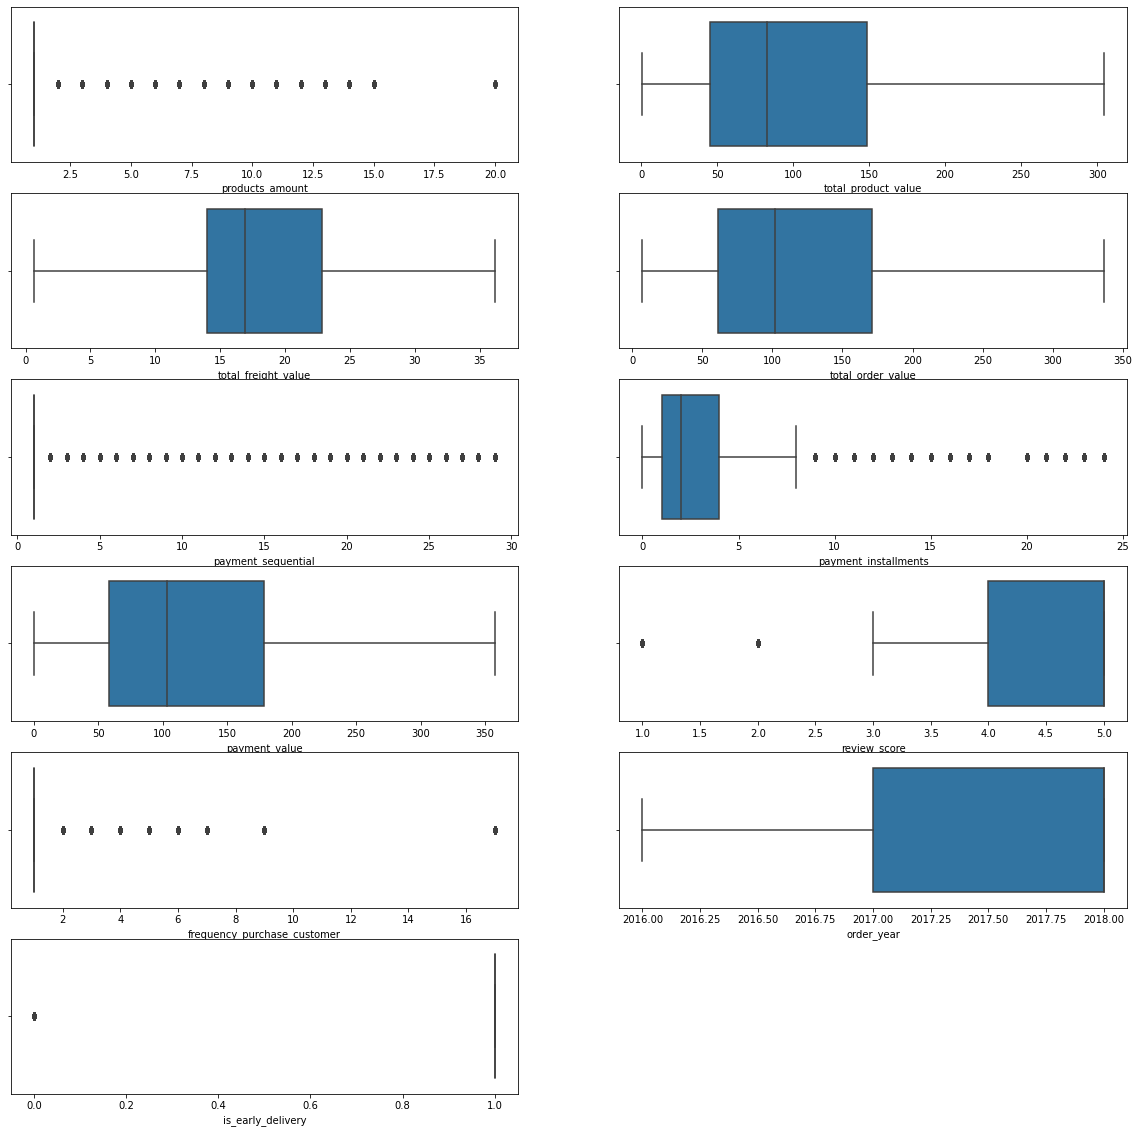

In [73]:
subplots_boxplot((20,20),df_olist)

Según los gráficos observadores, podemos concluir que se han corregido las distribuciones de las columnas de : **payment_value ,total_product_value , total_freight_value , total_order_value**

# **2. Análisis y Visualizaciones**

## **2.1. Análisis Univariado**

### **2.1.1. Variables Cuantitativas**

In [74]:
def subplot_hist(df):
  features= df.select_dtypes(exclude=['object']).columns
  plt.figure(figsize=(20,20))
  for i in range(len(features)):
    f = math.ceil(len(features)/2)
    c = i+1 if i<len(features) else i-1
    plt.subplot(f,2,c)
    sns.histplot(data=df,x=features[i],color='navy',bins=30);

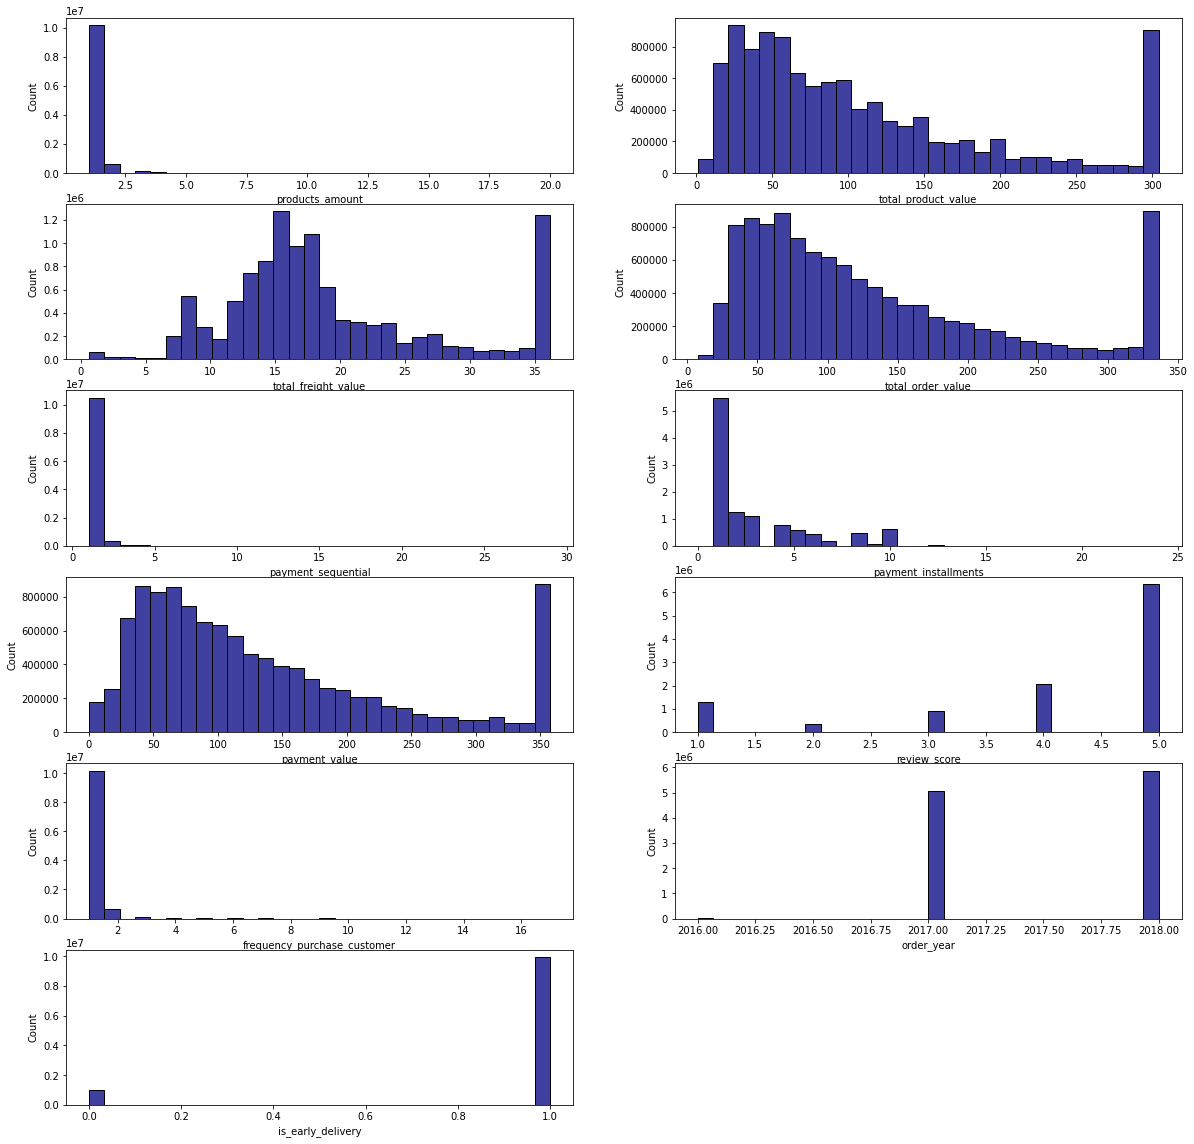

In [75]:
subplot_hist(df_olist)

En la gráfica anterior, podemos observar lo siguiente:
* La distribución de los pagos, total del producto y total de la orden **representan una asimetría a la derecha con mayor frecuencia en su máximo valor**. Esto nos indica que la mayoria de clientes realizan grandes compras en Olist Store
* La distribución del total de transporte **representa una forma binomial**. Esto nos indica que existe mayor frecuencia en el valor medio de costo de transporte. Sin embargo, también existe una mayor frecuencia en el máximo costo de transporte (esto se debe a las grandes compras de los clientes en Olist Store)

### **2.1.2. Variables Cualitativas**

In [76]:
def subplot_count(df):
  features = df.select_dtypes(include=['object']).columns
  features = features.drop(['customer_city','product_category_name','seller_city'])
  plt.figure(figsize=(15,15))
  for i in range(len(features)):
    f = math.ceil(len(features)/2)
    c = i+1 if i<len(features) else i-1
    plt.subplot(f,2,c)
    sns.countplot(data=df,x=features[i]);

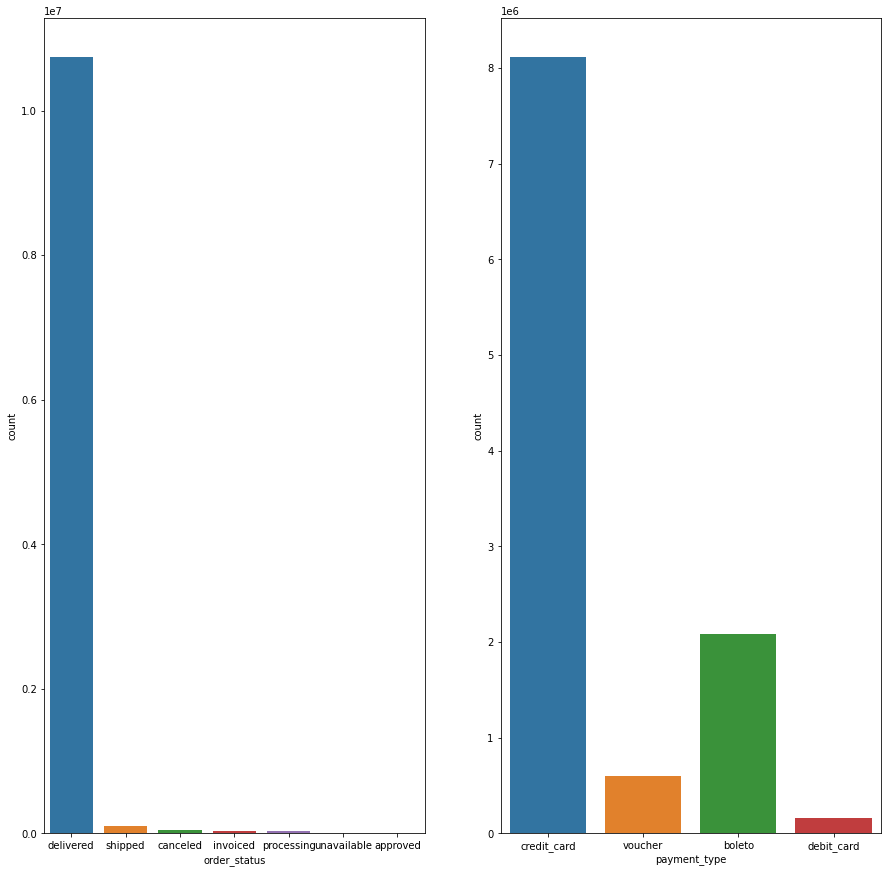

In [77]:
subplot_count(df_olist)

En la gráfica anterior, podemos observar lo siguiente:
* La mayoría de clientes **prefieren realizar sus pagos mediante tarjeta de crédito**
* La mayoría de estos de las órdenes **han sido entregados con éxito**

## **2.2. Análisis Bivariado**

### **2.2.1. Matriz de Correlación**

In [78]:
def matrix_correlation(df):
  plt.figure(figsize=(10,12))
  sns.heatmap(df.corr().round(2),annot=True,cmap='Blues')

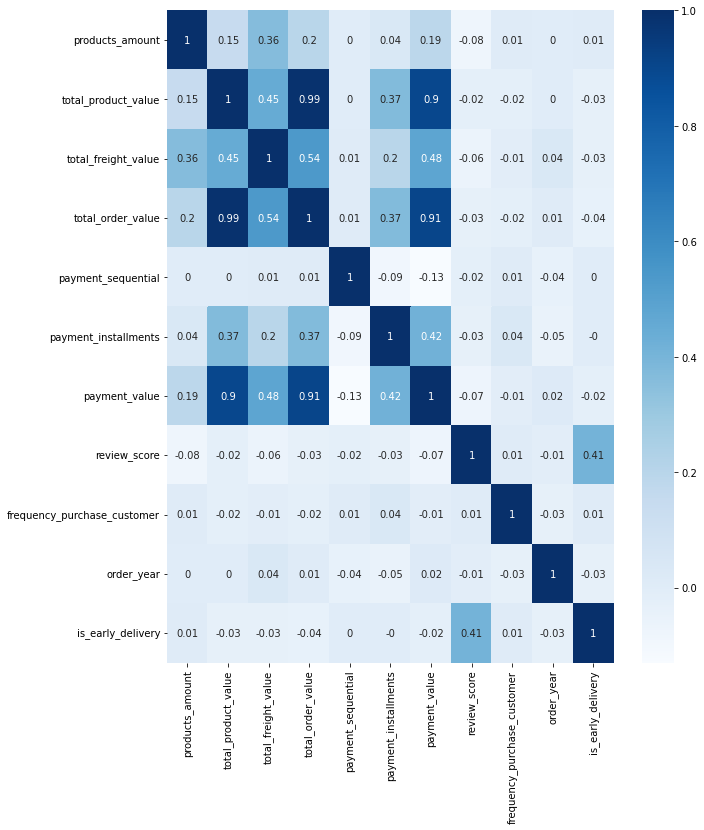

In [79]:
matrix_correlation(df_olist)

En la celda anterior, podemos visualizar la matriz de correlación donde vamos a identificar las correlaciones moderadas y fuertes con el objetivo de cruzar las variables para el posterior analisis bivariado

In [80]:
def extract_high_correlation(df):

  high_records=df.corr()[((df.corr()>=0.5)&(df.corr()<1))].notna().to_dict()

  dicc_col=dict(enumerate(df.corr().columns))
  
  variable_pairs=list()

  for index,record in high_records.items():
      c=0
      for value in record.values():
          if value:
              variable_pairs.append((index,dicc_col[c]))
          c+=1

  final_variable_pairs=list(set([tuple(sorted(i)) for i in variable_pairs]))
  return final_variable_pairs

In [81]:
extract_high_correlation(df_olist)

[('total_order_value', 'total_product_value'),
 ('payment_value', 'total_product_value'),
 ('total_freight_value', 'total_order_value'),
 ('payment_value', 'total_order_value')]

En la celda anterior, **hemos obtenido pares de variables con una correlación alta con un valor entre 0.5 a 1**

### **2.2.2. Diagrama de Dispersión**

In [82]:
def subplots_scatter(df,variables_high_correlation):
  plt.figure(figsize=(20,20))
  for i in range(len(variables_high_correlation)):
    f = math.ceil(len(variables_high_correlation)/2)
    c = i+1 if i<len(variables_high_correlation) else i-1
    plt.subplot(f,2,c)
    sns.scatterplot(data=df,x=variables_high_correlation[i][0],y=variables_high_correlation[i][1])

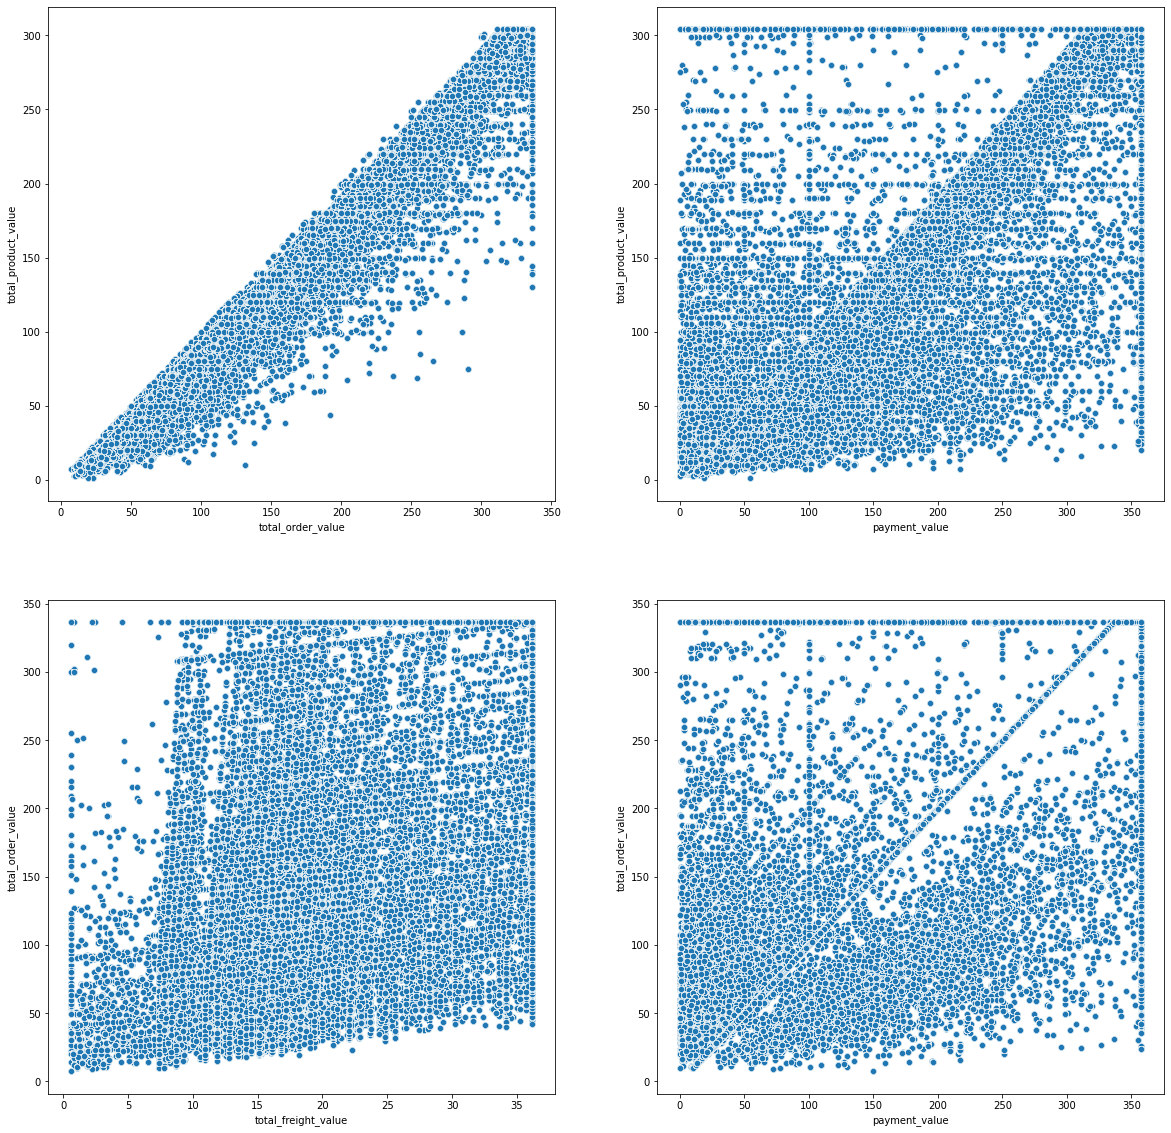

In [83]:
subplots_scatter(df_olist,extract_high_correlation(df_olist))

En la celda anterior, **hemos encontrado una tendencia lineal entre el total del producto con el valor de la orden**. Esto se explica a mayor costo del producto, mayor valor del total de la orden

### **2.2.3. Análisis de Multicolinealidad**

In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def variance_inflaction_df(df):
  vif_data = pd.DataFrame()

  df = df.select_dtypes(exclude=['object'])

  vif_data["feature"] = df.columns
  
  vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
  
  vif_data=vif_data[vif_data.VIF>5]

  vif_data=vif_data.sort_values(by='VIF',ascending=False).reset_index(drop=True)

  return vif_data

In [85]:
variance_inflaction_df(df_olist)

,feature,VIF
0,total_order_value,546.762158
1,total_product_value,412.540149
2,order_year,36.306813
3,total_freight_value,22.598513
4,payment_value,19.980262
5,is_early_delivery,13.134299
6,review_score,12.361393
7,frequency_purchase_customer,9.153208
8,products_amount,7.964676


En la celda anterior observamos **las variables que presentan problemas de colinealidad con otras variables explicativas**, por las que se debería evaluar su tratamiento posterior.

In [86]:
def plot_lm(df,x,y,hue=0):
  if hue != 0:
    sns.lmplot(x=x, y=y, data=df, hue=hue, fit_reg=False)
  else:
    sns.lmplot(x=x, y=y, data=df, fit_reg=False)

### **2.2.4. Analizando Clientes**

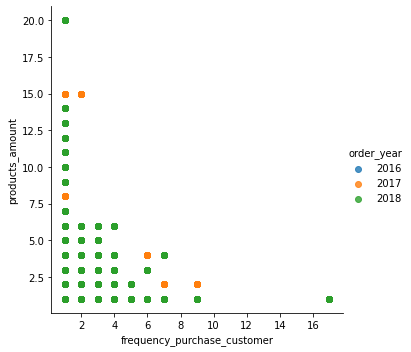

In [87]:
plot_lm(df_olist,'frequency_purchase_customer','products_amount','order_year')

En la gráfica anterior, **podemos observar que los clientes mas frecuentes cada vez llevan menos productos**. Probablemente sea necesario realizar promociones de productos para conservar la fidelización de clientes. Esta tendencia se observa en todos los años 

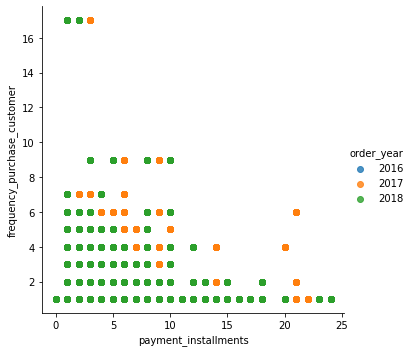

In [88]:
plot_lm(df_olist,'payment_installments','frequency_purchase_customer','order_year')

En la gráfica anterior, **podemos observar que los clientes mas frecuentes pagan con menos cuotas posibles**. Podemos afirmar que los clientes mas frecuentes no prefieren endeudarse ni pagar intereses en sus compras, lo que permite que compren nuevamente

### **2.2.5. Analizando Delivery**

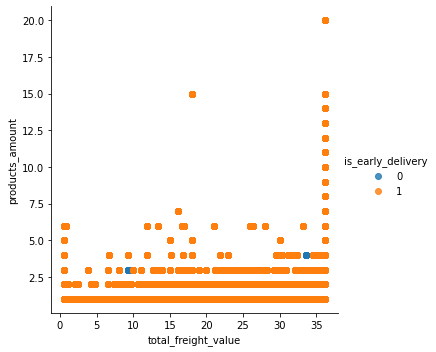

In [105]:
plot_lm(df_olist,'total_freight_value','products_amount','is_early_delivery')

En la gráfica anterior, **podemos observar que las entregas que no llegaron a tiempo son de órdenes de pocos productos**. Podemos afirmar que estas órdenes de compra tuvieron productos muy pesados y de difícil transporte

### **2.2.6. Analizando Score**

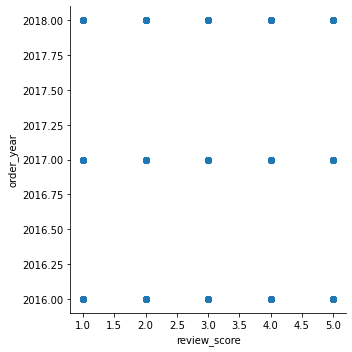

In [89]:
plot_lm(df_olist,'review_score','order_year')

En el gráfico anterior, **podemos observar que no existe una tendencia marcada con el paso de los años con el score de los productos**. Esto se deba a que todavia existen productos que no son bien recibidos por los clientes

### **2.2.7. Analizando Ciudades**

In [90]:
def plot_bar(df,x,y,hue):
  plt.figure(figsize=(10,12))
  sns.barplot(data=df,x=x, y=y, hue=hue)

In [91]:
df1 = df_olist.groupby(['customer_city']).agg({'payment_value':'sum','products_amount':'sum'}).sort_values(by='payment_value',ascending=False).head(5)
df1

,payment_value,products_amount
customer_city,,
rio de janeiro,1.336248e+08,1094275
sao paulo,9.580406e+07,893783
belo horizonte,6.285873e+07,537993
niteroi,2.973043e+07,247678
curitiba,2.217177e+07,189942


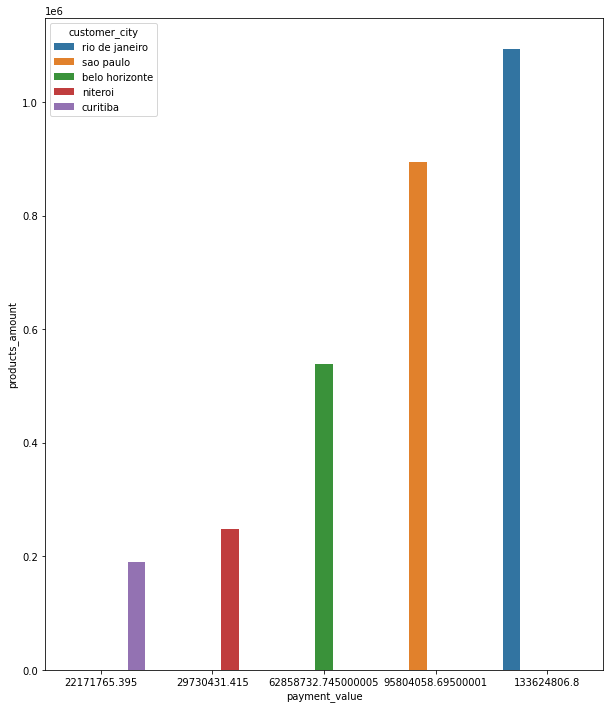

In [92]:
plot_bar(df1,'payment_value','products_amount',df1.index)

En el gráfico anterior, **podemos observar que el top 5 de ciudades de Brasil con mayor ventas en Olist Store**.

In [93]:
df1 = df_olist.groupby(['seller_city']).agg({'frequency_purchase_customer':'sum','total_order_value':'sum'}).sort_values(by='frequency_purchase_customer',ascending=False).head(5)
df1

,frequency_purchase_customer,total_order_value
seller_city,,
sao paulo,2838033,2.786962e+08
ibitinga,936322,8.707863e+07
curitiba,347571,5.039622e+07
santo andre,326946,2.717237e+07
belo horizonte,272469,2.442056e+07


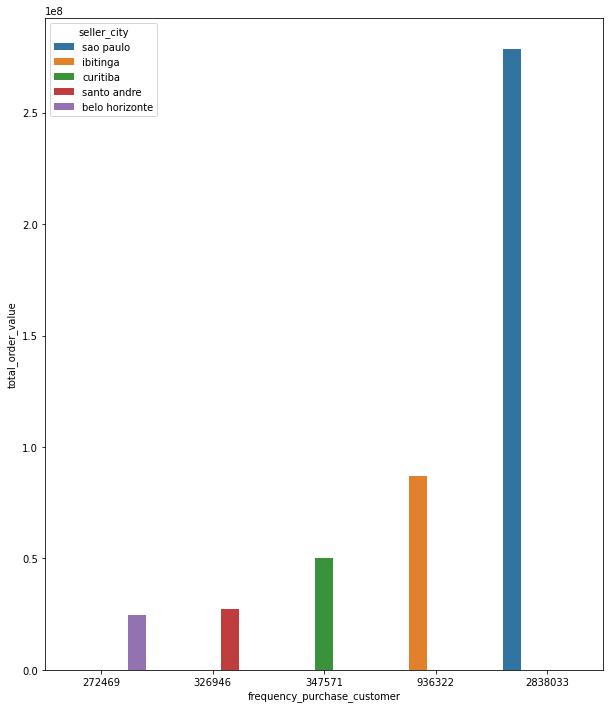

In [94]:
plot_bar(df1,'frequency_purchase_customer','total_order_value',df1.index)

En el gráfico anterior, **podemos observar que el top 5 de ciudades de Brasil con mayor número de compras de clientes frecuentes**.

### **2.2.8. Analizando Productos**

In [95]:
df1 = df_olist.groupby(['product_category_name']).agg({'payment_value':'sum','total_order_value':'sum'}).sort_values(by='payment_value',ascending=False).head(5)
df1

,payment_value,total_order_value
product_category_name,,
bed_bath_table,1.523821e+08,1.402907e+08
health_beauty,1.246832e+08,1.219706e+08
sports_leisure,1.107016e+08,1.096055e+08
furniture_decor,1.043751e+08,9.756965e+07
watches_gifts,1.021395e+08,9.980040e+07


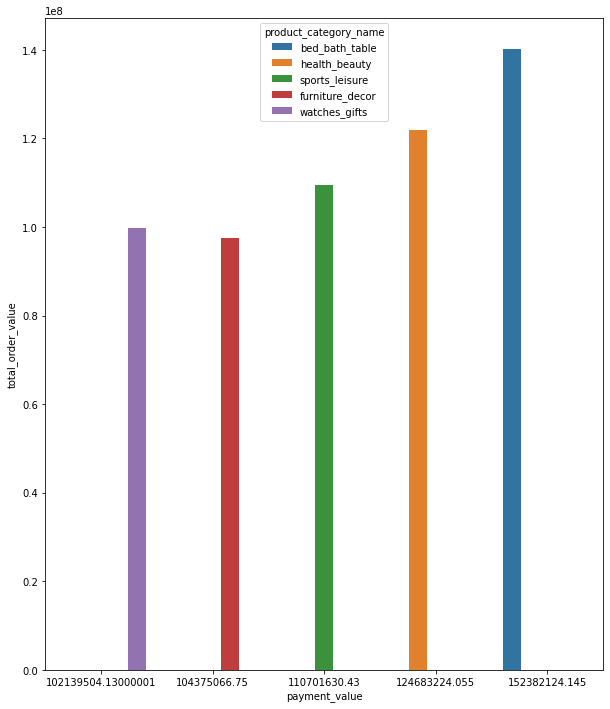

In [96]:
plot_bar(df1,'payment_value','total_order_value',df1.index)

En el gráfico anterior, **podemos observar que el top 5 de productos con mayor ventas. Las categorías que destacan son: cama_baño_mesa	, salud_belleza, deporte_ocio, muebles_decoración y relojes_regalos**

In [97]:
df1 = df_olist
df1['review_score_count'] = df_olist['review_score']
df1 = df_olist[df_olist['review_score'] == 5].groupby(['product_category_name','review_score'], as_index=False).agg({'review_score_count': 'count'}).sort_values(by='review_score_count',ascending=False).head(5)
df1

,product_category_name,review_score,review_score_count
7,bed_bath_table,5,593785
43,health_beauty,5,570769
64,sports_leisure,5,515510
39,furniture_decor,5,433676
15,computers_accessories,5,416265


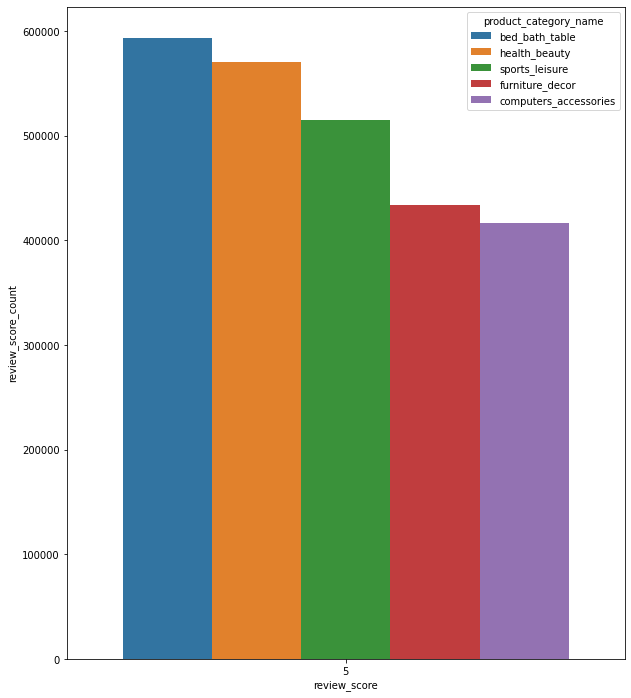

In [98]:
plot_bar(df1,'review_score','review_score_count','product_category_name')

En el gráfico anterior, podemos observar que el **top 5 de productos mejor calificados. Las categorías que destacan son: cama_baño_mesa , salud_belleza, deporte_ocio, muebles_decoración y ordenadores_accesorios**

In [103]:
df1 = df_olist[df_olist['review_score'] == 1].groupby(['product_category_name','review_score'], as_index=False).agg({'review_score_count': 'count'}).sort_values(by='review_score_count',ascending=False).head(5)
df1

,product_category_name,review_score,review_score_count
7,bed_bath_table,1,176988
14,computers_accessories,1,108617
38,furniture_decor,1,102008
42,health_beauty,1,96793
64,sports_leisure,1,94207


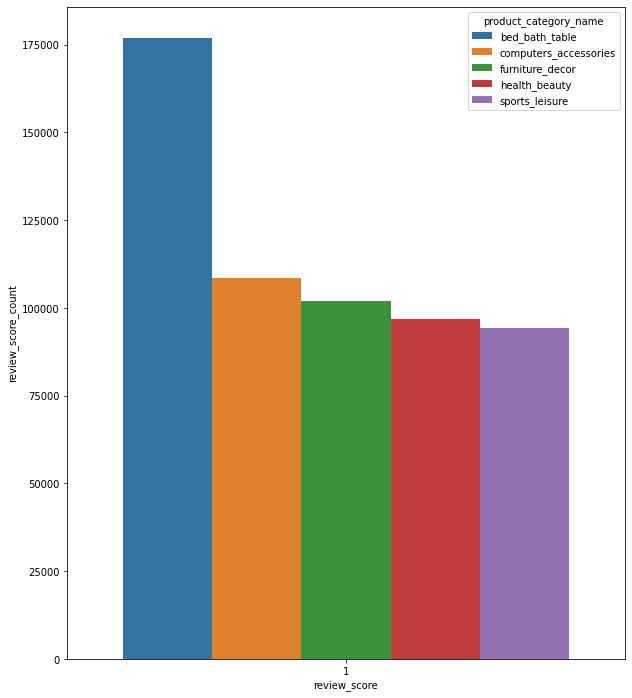

In [104]:
plot_bar(df1,'review_score','review_score_count','product_category_name')

En el gráfico anterior, podemos observar que el **top 5 de productos peor calificados. Las categorías que destacan son: cama_baño_mesa	 , ordenadores_accesorios	, muebles_decoración, salud_belleza y deporte ocio**

In [101]:
df1 = df_olist
df1['review_score_count'] = df_olist['review_score']
df1 = df_olist[df_olist['review_score'] == 5].groupby(['product_category_name','frequency_purchase_customer','review_score'], as_index=False).agg({'review_score_count': 'count'}).sort_values(by=['frequency_purchase_customer','review_score_count'],ascending=False).head(10)
df1

,product_category_name,frequency_purchase_customer,review_score,review_score_count
217,sports_leisure,17,5,319
95,fashion_bags_accessories,17,5,87
75,costruction_tools_tools,17,5,29
31,bed_bath_table,7,5,2048
129,furniture_decor,7,5,820
166,housewares,7,5,410
69,cool_stuff,7,5,368
198,perfumery,7,5,42
146,health_beauty,7,5,21
222,stationery,7,5,21


En el dataframe anterior, podemos observar que **los clientes mas frecuentes prefieren productos de ocio_deportivo, moda_bolsos_accesorios, herramientas_de_construcción, baño_mesa_cama, muebles_decoración , casa_construcción, artículos para el hogar, cosas interesantes, perfumería y salud_belleza y papelería**

In [102]:
df1 = df_olist
df1['review_score_count'] = df_olist['review_score']
df1 = df_olist[df_olist['review_score'] == 1].groupby(['product_category_name','frequency_purchase_customer','review_score'], as_index=False).agg({'review_score_count': 'count'}).sort_values(by=['frequency_purchase_customer','review_score_count'],ascending=False).head(10)
df1

,product_category_name,frequency_purchase_customer,review_score,review_score_count
19,bed_bath_table,9,1,186
18,bed_bath_table,5,1,310
107,luggage_accessories,5,1,155
143,watches_gifts,5,1,54
32,computers_accessories,4,1,99
14,baby,4,1,97
76,furniture_decor,4,1,59
142,watches_gifts,4,1,52
129,sports_leisure,4,1,45
138,toys,4,1,38


En el dataframe anterior, podemos observar que **los clientes mas frecuentes no les gusta productos de mesa_de_baño_de_cama, accesorios_de_maletas, relojes_regalos, ordenadores_accesorios	, bebé, ocio_deportivo , juguetes**

# **3. Insights y Recomendaciones**

## **3.1. Insights Encontrados**

En el presente análisis, se han encontrado los siguientes Insights:
* Los clientes prefieren realizar sus pagos con tarjetas de crédito
* Los clientes mas frecuentes cada vez llevan menos productos y prefieren pagar en pequeñas cuotas. Esta tendencia se observa en todos los años
* La entrega de productos que no llegaron a tiempo fueron de pocos productos (pesados y difíciles de transportar)
* La mayoría de clientes y los mejores vendedores son de la región Sur de Brasil
* Los productos mas vendidos y mejores rankeados son del hogar, belleza, ocio y decoración
* Los clientes mas frecuentes tienen mayor preferencia en productos deportivo, moda, construcción, decoración, hogar, perfumería y belleza. Mientras que su peor preferencia de productos son los de regalos, accesorios, bebes y juguetes

## **3.2. Recomendaciones**

En el presente análisis, se han planteado las siguientes recomendaciones:
* Es necesario que los clientes mas frecuentes puedan recibir promociones y recomendaciones de productos, para mejorar la fidelización y evitar la tendencia que lleven menos productos
* Es necesario que los productos peor rankeados de los clientes mas frecuentes tengan que ser evaluados por sus vendedores y/o mejorar su propuesta de valor
* Los pequeños vendedores de Olist Store sigan el ejemplo de los vendedores de la región Sur, porque lograron posicionar mejor sus productos
* Algunas variables presentan problemas de colinealidad con otras variables explicativas, es necesario evaluar su tratamiento posterior.
